In [3]:
import numpy as np
import pandas as pd

In [247]:
def load_data(path, headers=None, skiprows=0):
	data = pd.read_csv(path, skiprows=skiprows)
	time = np.ravel(data[data.columns[0]].to_numpy())
	sig = np.ravel(data[data.columns[1]].to_numpy())
	return time, sig


In [248]:
file = "noise/0x9_off.csv"
dtime, dsignal = load_data(file, skiprows=22)
t0 = np.mean(np.ediff1d(dtime))
fs = 1 / t0
t0 = round(t0, 10)
fs = round(fs, 10)
print(f'sig={dsignal},mean={np.mean(dsignal)}')

sig=[ 0.00195712  0.00090612 -0.00127753 ...  0.00290539 -0.00058213
 -0.00084817],mean=0.0018536768788578024


$$
\sigma^2(\tau) = \frac{1}{2 \tau^2 (L-2m)}\sum_{k=1}^{L-2m}(\theta_{k+2m} - 2 \theta_{k+m} + \theta_{k})^2
$$

In [359]:
import matplotlib.pyplot as plt

def overlapped_allan_variance(sig, t0, maxNumM=10000):
	print(f'sig={sig}')
	print(np.all(sig > 0))
	L = len(sig)
	sense = np.cumsum(sig)
	maxM = L // 2 - 1 #2**np.floor(np.log2(L//2))
	print(f'L={L}')
	print()
	print(f'maxM={maxM}')
	print()
	print(f'sense={sense}')
	print()
	print(f't0={t0}')
	#m = np.logspace(np.log10(1), np.log10(maxM), maxNumM)
	m = np.linspace(1, maxM - 1, maxM + 1)
	#m = np.ceil(m)
	#m = np.unique(m)
	print(f'm={m}')
	print()
	tau = m * t0

	print(f'tau={tau}')
	print()
	plt.figure()
	plt.plot(sense)
	#plt.figure()
	#plt.plot(tau)

	avar = np.zeros(m.size)
	#L = 2 * int(maxM)
	#L = maxM * 2 + 1
	for i in range(m.size):
		mi = int(m[i])
		avar[i] = np.sum((sense[2*mi:L]- 2*sense[mi:L-mi] + sense[:L-2*mi])**2)
		#avar[i] = np.sum((sense[mi:L] - sense[:L-mi])**2)

	avar /= (2*tau**2 * (L-2*m))
	#avar /= 2 * (L-2*m)

	return tau, avar

sig=[ 0.00195712  0.00408019  0.00519968 ...  0.0036324   0.00302919
 -0.00058213]
False
L=80001

maxM=39999

sense=[1.95712300e-03 6.03731600e-03 1.12369930e-02 ... 1.50362903e+02
 1.50365932e+02 1.50365350e+02]

t0=0.001
m=[1.00000000e+00 1.99995000e+00 2.99990000e+00 ... 3.99960001e+04
 3.99970001e+04 3.99980000e+04]

tau=[1.00000000e-03 1.99995000e-03 2.99990000e-03 ... 3.99960001e+01
 3.99970001e+01 3.99980000e+01]



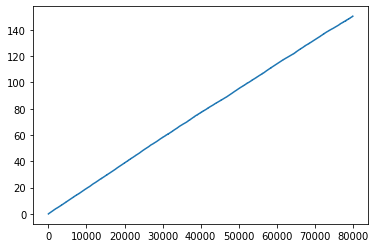

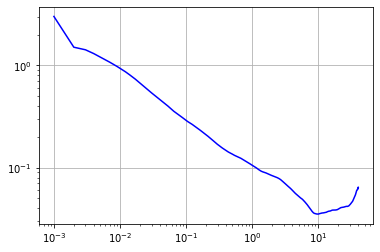

In [360]:
tau, avar = overlapped_allan_variance(dsignal.copy()[::10], t0*10)
adev = np.sqrt(avar)
plt.figure()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.plot(tau, adev, color='b')